## Classifying Good Product Reviews: Deep Learning Model

**Team J Cubed**: James Wei, Jessica Ko, Jay Patel

CS 294-129, Fall 2016

**NOTE:** Most of the code for data handling, featurization, and model construction lies outside of this notebook. Please see the Python scripts in {src_root}/lib for exact implementation details.

### Organize imports

In [1]:
from __future__ import division, print_function, absolute_import
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%autosave 5

/u/74/surikua1/unix/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Autosaving every 5 seconds


### Set network parameters

In [2]:
# Dataset/Featurization Config
path = '/u/74/surikua1/unix/Downloads/full_cols_good_50k.csv'
label = 'good'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = 'genesisgood_run1'
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [3]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [4]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

### Configure dataset

In [5]:
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at /u/74/surikua1/unix/Downloads/full_cols_good_50k.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
doc list created: 50000
Tuning tf-idf classifier.


/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Featurizing training set.
Featurizing test set.
Finished configuring dataset.


### Prepare model configurations

In [6]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [7]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [8]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [9]:
# Run forward pass
logits = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [10]:
# Initializing the variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Train model

In [11]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.683829, Training Accuracy= 0.60000
Iter 300, Minibatch Loss= 0.637146, Training Accuracy= 0.73333
Iter 450, Minibatch Loss= 0.698429, Training Accuracy= 0.33333
Iter 600, Minibatch Loss= 0.643174, Training Accuracy= 0.66667
Iter 750, Minibatch Loss= 0.679965, Training Accuracy= 0.53333
Validation Accuracy: 0.5949599
Validation Loss: 0.67892796


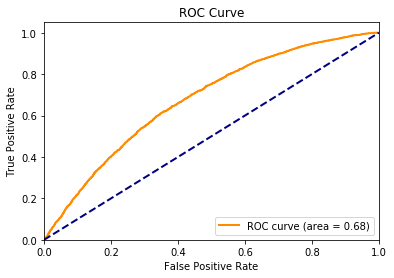

Iter 900, Minibatch Loss= 0.655948, Training Accuracy= 0.53333
Iter 1050, Minibatch Loss= 0.634784, Training Accuracy= 0.93333
Iter 1200, Minibatch Loss= 0.716894, Training Accuracy= 0.53333
Iter 1350, Minibatch Loss= 0.681273, Training Accuracy= 0.66667
Iter 1500, Minibatch Loss= 0.713092, Training Accuracy= 0.46667
Validation Accuracy: 0.62567997
Validation Loss: 0.6731173


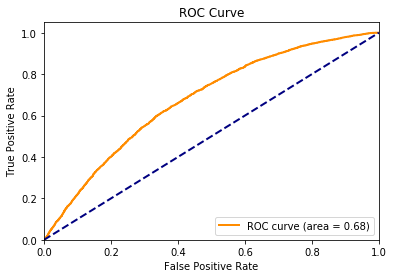

Iter 1650, Minibatch Loss= 0.707250, Training Accuracy= 0.40000
Iter 1800, Minibatch Loss= 0.569051, Training Accuracy= 0.80000
Iter 1950, Minibatch Loss= 0.561071, Training Accuracy= 0.66667
Iter 2100, Minibatch Loss= 0.699796, Training Accuracy= 0.40000
Iter 2250, Minibatch Loss= 0.618473, Training Accuracy= 0.80000
Validation Accuracy: 0.6339999
Validation Loss: 0.657342


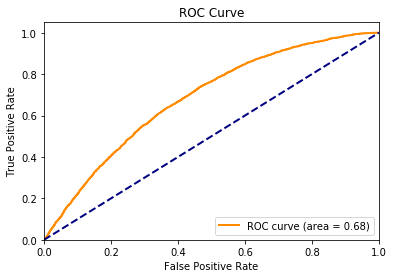

Iter 2400, Minibatch Loss= 0.648878, Training Accuracy= 0.66667
Iter 2550, Minibatch Loss= 0.694813, Training Accuracy= 0.60000
Iter 2700, Minibatch Loss= 0.571386, Training Accuracy= 0.73333
Iter 2850, Minibatch Loss= 0.651578, Training Accuracy= 0.53333
Iter 3000, Minibatch Loss= 0.589170, Training Accuracy= 0.73333
Validation Accuracy: 0.62119997
Validation Loss: 0.6489302
Iter 3150, Minibatch Loss= 0.586505, Training Accuracy= 0.60000
Iter 3300, Minibatch Loss= 0.568077, Training Accuracy= 0.66667
Iter 3450, Minibatch Loss= 0.708671, Training Accuracy= 0.66667
Iter 3600, Minibatch Loss= 0.661909, Training Accuracy= 0.53333
Iter 3750, Minibatch Loss= 0.604856, Training Accuracy= 0.73333
Validation Accuracy: 0.64391994
Validation Loss: 0.6372303


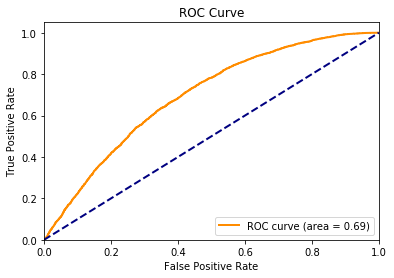

Iter 3900, Minibatch Loss= 0.550695, Training Accuracy= 0.73333
Iter 4050, Minibatch Loss= 0.647917, Training Accuracy= 0.53333
Iter 4200, Minibatch Loss= 0.657749, Training Accuracy= 0.40000
Iter 4350, Minibatch Loss= 0.781475, Training Accuracy= 0.53333
Iter 4500, Minibatch Loss= 0.678219, Training Accuracy= 0.60000
Validation Accuracy: 0.62455994
Validation Loss: 0.6543694
Iter 4650, Minibatch Loss= 0.582427, Training Accuracy= 0.66667
Iter 4800, Minibatch Loss= 0.712865, Training Accuracy= 0.53333
Iter 4950, Minibatch Loss= 0.594549, Training Accuracy= 0.66667
Iter 5100, Minibatch Loss= 0.711219, Training Accuracy= 0.46667
Iter 5250, Minibatch Loss= 0.642907, Training Accuracy= 0.80000
Validation Accuracy: 0.63199997
Validation Loss: 0.6582771
Iter 5400, Minibatch Loss= 0.630617, Training Accuracy= 0.73333
Iter 5550, Minibatch Loss= 0.582655, Training Accuracy= 0.80000
Iter 5700, Minibatch Loss= 0.675086, Training Accuracy= 0.53333
Iter 5850, Minibatch Loss= 0.628291, Training Accu

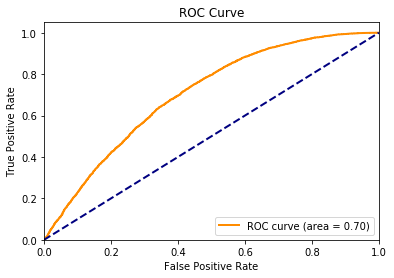

Iter 6150, Minibatch Loss= 0.528091, Training Accuracy= 0.66667
Iter 6300, Minibatch Loss= 0.812671, Training Accuracy= 0.46667
Iter 6450, Minibatch Loss= 0.666891, Training Accuracy= 0.53333
Iter 6600, Minibatch Loss= 0.599683, Training Accuracy= 0.73333
Iter 6750, Minibatch Loss= 0.697032, Training Accuracy= 0.60000
Validation Accuracy: 0.64935994
Validation Loss: 0.63595665


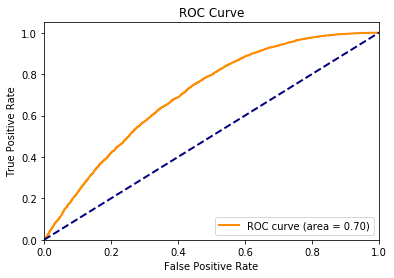

Iter 6900, Minibatch Loss= 0.665867, Training Accuracy= 0.66667
Iter 7050, Minibatch Loss= 0.612065, Training Accuracy= 0.60000
Iter 7200, Minibatch Loss= 0.446090, Training Accuracy= 0.93333
Iter 7350, Minibatch Loss= 0.567932, Training Accuracy= 0.66667
Iter 7500, Minibatch Loss= 0.675090, Training Accuracy= 0.66667
Validation Accuracy: 0.64031994
Validation Loss: 0.61985695
Iter 7650, Minibatch Loss= 0.593135, Training Accuracy= 0.66667
Iter 7800, Minibatch Loss= 0.606784, Training Accuracy= 0.53333
Iter 7950, Minibatch Loss= 0.698487, Training Accuracy= 0.60000
Iter 8100, Minibatch Loss= 0.467802, Training Accuracy= 0.73333
Iter 8250, Minibatch Loss= 0.660395, Training Accuracy= 0.66667
Validation Accuracy: 0.62591994
Validation Loss: 0.63462484
Iter 8400, Minibatch Loss= 0.622676, Training Accuracy= 0.73333
Iter 8550, Minibatch Loss= 0.645213, Training Accuracy= 0.66667
Iter 8700, Minibatch Loss= 0.604917, Training Accuracy= 0.60000
Iter 8850, Minibatch Loss= 0.573792, Training Ac

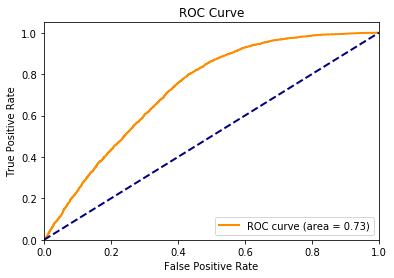

Iter 9150, Minibatch Loss= 0.503182, Training Accuracy= 0.86667
Iter 9300, Minibatch Loss= 0.557984, Training Accuracy= 0.80000
Iter 9450, Minibatch Loss= 0.695600, Training Accuracy= 0.40000
Iter 9600, Minibatch Loss= 0.756676, Training Accuracy= 0.53333
Iter 9750, Minibatch Loss= 0.520798, Training Accuracy= 0.93333
Validation Accuracy: 0.6364799
Validation Loss: 0.6311235
Iter 9900, Minibatch Loss= 0.754971, Training Accuracy= 0.66667
Iter 10050, Minibatch Loss= 0.555077, Training Accuracy= 0.80000
Iter 10200, Minibatch Loss= 0.781345, Training Accuracy= 0.60000
Iter 10350, Minibatch Loss= 0.791464, Training Accuracy= 0.66667
Iter 10500, Minibatch Loss= 0.456731, Training Accuracy= 0.86667
Validation Accuracy: 0.6675199
Validation Loss: 0.60598415
Iter 10650, Minibatch Loss= 0.632418, Training Accuracy= 0.60000
Iter 10800, Minibatch Loss= 0.690303, Training Accuracy= 0.60000
Iter 10950, Minibatch Loss= 0.704485, Training Accuracy= 0.60000
Iter 11100, Minibatch Loss= 0.602588, Traini

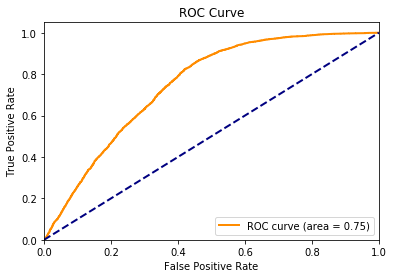

Iter 13650, Minibatch Loss= 0.614144, Training Accuracy= 0.66667
Iter 13800, Minibatch Loss= 0.518173, Training Accuracy= 0.66667
Iter 13950, Minibatch Loss= 0.644641, Training Accuracy= 0.60000
Iter 14100, Minibatch Loss= 0.539691, Training Accuracy= 0.86667
Iter 14250, Minibatch Loss= 0.461121, Training Accuracy= 0.86667
Validation Accuracy: 0.69983983
Validation Loss: 0.5874188
Iter 14400, Minibatch Loss= 0.693695, Training Accuracy= 0.53333
Iter 14550, Minibatch Loss= 0.623085, Training Accuracy= 0.53333
Iter 14700, Minibatch Loss= 0.432687, Training Accuracy= 0.93333
Iter 14850, Minibatch Loss= 0.659338, Training Accuracy= 0.73333
Iter 15000, Minibatch Loss= 0.536093, Training Accuracy= 0.66667
Validation Accuracy: 0.65503997
Validation Loss: 0.6099799
Iter 15150, Minibatch Loss= 0.604021, Training Accuracy= 0.66667
Iter 15300, Minibatch Loss= 0.522302, Training Accuracy= 0.80000
Iter 15450, Minibatch Loss= 0.455921, Training Accuracy= 0.73333
Iter 15600, Minibatch Loss= 0.478743,

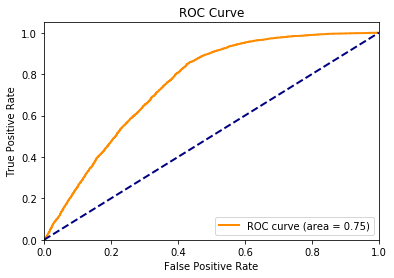

Iter 15900, Minibatch Loss= 0.605511, Training Accuracy= 0.60000
Iter 16050, Minibatch Loss= 0.531383, Training Accuracy= 0.73333
Iter 16200, Minibatch Loss= 0.593601, Training Accuracy= 0.66667
Iter 16350, Minibatch Loss= 0.397713, Training Accuracy= 0.93333
Iter 16500, Minibatch Loss= 0.514643, Training Accuracy= 0.80000
Validation Accuracy: 0.72135985
Validation Loss: 0.56157476


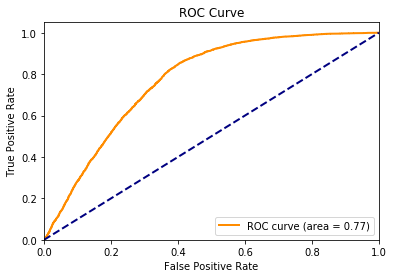

Iter 16650, Minibatch Loss= 0.549880, Training Accuracy= 0.80000
Iter 16800, Minibatch Loss= 0.390930, Training Accuracy= 0.93333
Iter 16950, Minibatch Loss= 0.527807, Training Accuracy= 0.73333
Iter 17100, Minibatch Loss= 0.617303, Training Accuracy= 0.60000
Iter 17250, Minibatch Loss= 0.415345, Training Accuracy= 0.80000
Validation Accuracy: 0.6945599
Validation Loss: 0.60321015
Iter 17400, Minibatch Loss= 0.525883, Training Accuracy= 0.86667
Iter 17550, Minibatch Loss= 0.683666, Training Accuracy= 0.53333
Iter 17700, Minibatch Loss= 0.383054, Training Accuracy= 0.93333
Iter 17850, Minibatch Loss= 0.537100, Training Accuracy= 0.60000
Iter 18000, Minibatch Loss= 0.361033, Training Accuracy= 0.86667
Validation Accuracy: 0.7121599
Validation Loss: 0.6221175
Iter 18150, Minibatch Loss= 0.300179, Training Accuracy= 0.93333
Iter 18300, Minibatch Loss= 0.321524, Training Accuracy= 0.93333
Iter 18450, Minibatch Loss= 0.620911, Training Accuracy= 0.73333
Iter 18600, Minibatch Loss= 0.770831, 

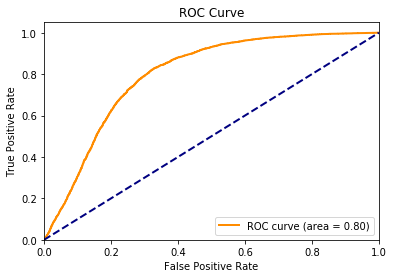

Iter 19650, Minibatch Loss= 0.670321, Training Accuracy= 0.53333
Iter 19800, Minibatch Loss= 0.605633, Training Accuracy= 0.73333
Iter 19950, Minibatch Loss= 0.770968, Training Accuracy= 0.46667
Iter 20100, Minibatch Loss= 0.589817, Training Accuracy= 0.73333
Iter 20250, Minibatch Loss= 0.448562, Training Accuracy= 0.86667
Validation Accuracy: 0.7470398
Validation Loss: 0.54255235
Iter 20400, Minibatch Loss= 0.514617, Training Accuracy= 0.73333
Iter 20550, Minibatch Loss= 0.657928, Training Accuracy= 0.66667
Iter 20700, Minibatch Loss= 0.315200, Training Accuracy= 1.00000
Iter 20850, Minibatch Loss= 0.405604, Training Accuracy= 0.80000
Iter 21000, Minibatch Loss= 0.531908, Training Accuracy= 0.73333
Validation Accuracy: 0.6320799
Validation Loss: 0.67778546
Iter 21150, Minibatch Loss= 0.628938, Training Accuracy= 0.60000
Iter 21300, Minibatch Loss= 0.752255, Training Accuracy= 0.66667
Iter 21450, Minibatch Loss= 0.554904, Training Accuracy= 0.73333
Iter 21600, Minibatch Loss= 0.460989,

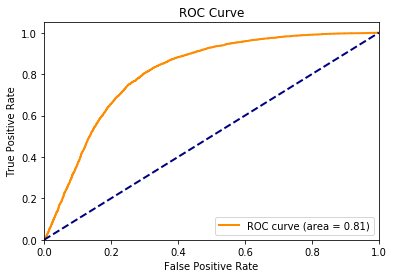

Iter 22650, Minibatch Loss= 0.431895, Training Accuracy= 0.80000
Iter 22800, Minibatch Loss= 0.444914, Training Accuracy= 0.86667
Iter 22950, Minibatch Loss= 0.530574, Training Accuracy= 0.73333
Iter 23100, Minibatch Loss= 0.525025, Training Accuracy= 0.66667
Iter 23250, Minibatch Loss= 0.460640, Training Accuracy= 0.80000
Validation Accuracy: 0.7371198
Validation Loss: 0.5745367
Iter 23400, Minibatch Loss= 0.525490, Training Accuracy= 0.80000
Iter 23550, Minibatch Loss= 0.601233, Training Accuracy= 0.73333
Iter 23700, Minibatch Loss= 0.488220, Training Accuracy= 0.73333
Iter 23850, Minibatch Loss= 0.496167, Training Accuracy= 0.66667
Iter 24000, Minibatch Loss= 0.429548, Training Accuracy= 0.86667
Validation Accuracy: 0.7207998
Validation Loss: 0.5536354
Iter 24150, Minibatch Loss= 0.429943, Training Accuracy= 0.80000
Iter 24300, Minibatch Loss= 0.461038, Training Accuracy= 0.80000
Iter 24450, Minibatch Loss= 0.339384, Training Accuracy= 0.93333
Iter 24600, Minibatch Loss= 0.568105, T

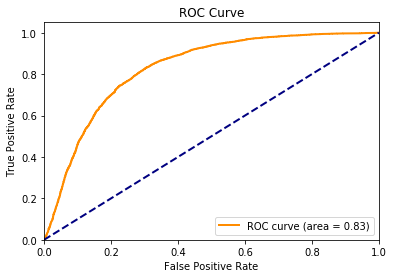

Iter 25650, Minibatch Loss= 0.415879, Training Accuracy= 0.93333
Iter 25800, Minibatch Loss= 0.287368, Training Accuracy= 0.93333
Iter 25950, Minibatch Loss= 0.574828, Training Accuracy= 0.73333
Iter 26100, Minibatch Loss= 0.631005, Training Accuracy= 0.66667
Iter 26250, Minibatch Loss= 0.585290, Training Accuracy= 0.73333
Validation Accuracy: 0.6636799
Validation Loss: 0.60690004
Iter 26400, Minibatch Loss= 0.562917, Training Accuracy= 0.66667
Iter 26550, Minibatch Loss= 0.518783, Training Accuracy= 0.73333
Iter 26700, Minibatch Loss= 0.649050, Training Accuracy= 0.53333
Iter 26850, Minibatch Loss= 0.401992, Training Accuracy= 0.80000
Iter 27000, Minibatch Loss= 0.702231, Training Accuracy= 0.60000
Validation Accuracy: 0.75159985
Validation Loss: 0.5386913


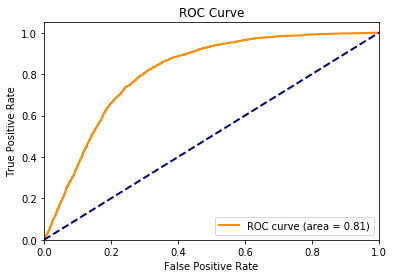

Iter 27150, Minibatch Loss= 0.527985, Training Accuracy= 0.73333
Iter 27300, Minibatch Loss= 0.478178, Training Accuracy= 0.73333
Iter 27450, Minibatch Loss= 0.628748, Training Accuracy= 0.66667
Iter 27600, Minibatch Loss= 0.915226, Training Accuracy= 0.53333
Iter 27750, Minibatch Loss= 0.526758, Training Accuracy= 0.73333
Validation Accuracy: 0.7559198
Validation Loss: 0.53017724


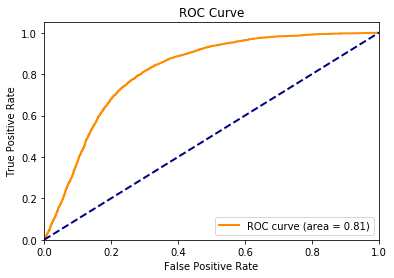

Iter 27900, Minibatch Loss= 0.593140, Training Accuracy= 0.60000
Iter 28050, Minibatch Loss= 0.435703, Training Accuracy= 0.86667
Iter 28200, Minibatch Loss= 0.565799, Training Accuracy= 0.66667
Iter 28350, Minibatch Loss= 0.379159, Training Accuracy= 0.93333
Iter 28500, Minibatch Loss= 0.520127, Training Accuracy= 0.73333
Validation Accuracy: 0.71503985
Validation Loss: 0.564339
Iter 28650, Minibatch Loss= 0.590465, Training Accuracy= 0.66667
Iter 28800, Minibatch Loss= 0.587423, Training Accuracy= 0.73333
Iter 28950, Minibatch Loss= 0.494969, Training Accuracy= 0.80000
Iter 29100, Minibatch Loss= 0.603023, Training Accuracy= 0.66667
Iter 29250, Minibatch Loss= 0.616421, Training Accuracy= 0.66667
Validation Accuracy: 0.74439985
Validation Loss: 0.5331712
Iter 29400, Minibatch Loss= 0.484247, Training Accuracy= 0.73333
Iter 29550, Minibatch Loss= 0.517603, Training Accuracy= 0.73333
Iter 29700, Minibatch Loss= 0.364282, Training Accuracy= 0.86667
Iter 29850, Minibatch Loss= 0.403619, 

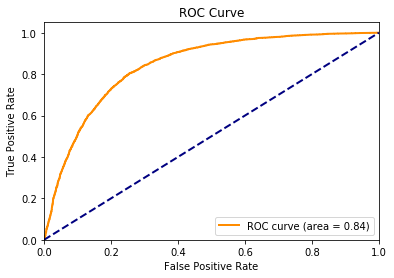

Iter 35400, Minibatch Loss= 0.442564, Training Accuracy= 0.86667
Iter 35550, Minibatch Loss= 0.672500, Training Accuracy= 0.60000
Iter 35700, Minibatch Loss= 0.383822, Training Accuracy= 0.93333
Iter 35850, Minibatch Loss= 0.753345, Training Accuracy= 0.53333
Iter 36000, Minibatch Loss= 0.635132, Training Accuracy= 0.66667
Validation Accuracy: 0.7219199
Validation Loss: 0.5827312
Iter 36150, Minibatch Loss= 0.399260, Training Accuracy= 0.86667
Iter 36300, Minibatch Loss= 0.649400, Training Accuracy= 0.80000
Iter 36450, Minibatch Loss= 0.558578, Training Accuracy= 0.73333
Iter 36600, Minibatch Loss= 0.524926, Training Accuracy= 0.73333
Iter 36750, Minibatch Loss= 0.420438, Training Accuracy= 0.86667
Validation Accuracy: 0.69879985
Validation Loss: 0.587955
Iter 36900, Minibatch Loss= 0.437023, Training Accuracy= 0.86667
Iter 37050, Minibatch Loss= 0.900884, Training Accuracy= 0.40000
Iter 37200, Minibatch Loss= 0.521064, Training Accuracy= 0.73333
Iter 37350, Minibatch Loss= 0.355918, T

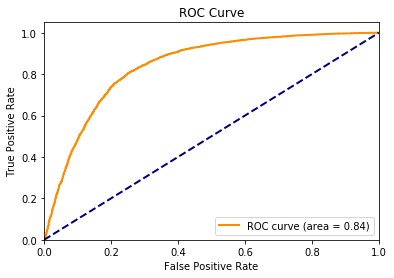

Iter 39900, Minibatch Loss= 0.666187, Training Accuracy= 0.60000
Iter 40050, Minibatch Loss= 0.544505, Training Accuracy= 0.80000
Iter 40200, Minibatch Loss= 0.409224, Training Accuracy= 0.73333
Iter 40350, Minibatch Loss= 0.462280, Training Accuracy= 0.80000
Iter 40500, Minibatch Loss= 0.533521, Training Accuracy= 0.66667
Validation Accuracy: 0.7540798
Validation Loss: 0.51737887
Iter 40650, Minibatch Loss= 0.351477, Training Accuracy= 0.93333
Iter 40800, Minibatch Loss= 0.423610, Training Accuracy= 0.86667
Iter 40950, Minibatch Loss= 0.427298, Training Accuracy= 0.86667
Iter 41100, Minibatch Loss= 0.666164, Training Accuracy= 0.53333
Iter 41250, Minibatch Loss= 0.625589, Training Accuracy= 0.60000
Validation Accuracy: 0.76191974
Validation Loss: 0.50941736
Iter 41400, Minibatch Loss= 0.514951, Training Accuracy= 0.73333
Iter 41550, Minibatch Loss= 0.486290, Training Accuracy= 0.86667
Iter 41700, Minibatch Loss= 0.545553, Training Accuracy= 0.73333
Iter 41850, Minibatch Loss= 0.799911

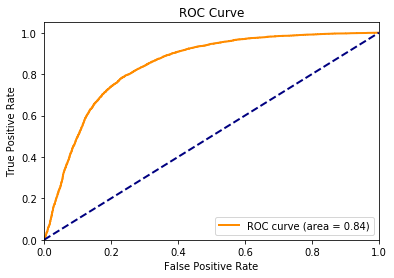

Iter 79650, Minibatch Loss= 0.374043, Training Accuracy= 0.80000
Iter 79800, Minibatch Loss= 0.458380, Training Accuracy= 0.73333
Iter 79950, Minibatch Loss= 0.572896, Training Accuracy= 0.73333
Iter 80100, Minibatch Loss= 0.516962, Training Accuracy= 0.80000
Iter 80250, Minibatch Loss= 0.380010, Training Accuracy= 0.80000
Validation Accuracy: 0.7736798
Validation Loss: 0.497742
Iter 80400, Minibatch Loss= 0.526588, Training Accuracy= 0.73333
Iter 80550, Minibatch Loss= 0.344993, Training Accuracy= 0.86667
Iter 80700, Minibatch Loss= 0.688842, Training Accuracy= 0.73333
Iter 80850, Minibatch Loss= 0.384488, Training Accuracy= 0.86667
Iter 81000, Minibatch Loss= 0.736375, Training Accuracy= 0.53333
Validation Accuracy: 0.7633597
Validation Loss: 0.5019012
Iter 81150, Minibatch Loss= 0.521708, Training Accuracy= 0.66667
Iter 81300, Minibatch Loss= 0.844639, Training Accuracy= 0.46667
Iter 81450, Minibatch Loss= 0.648157, Training Accuracy= 0.66667
Iter 81600, Minibatch Loss= 0.648097, Tr

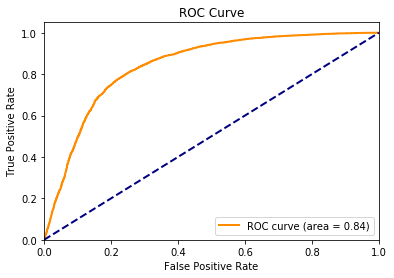

Iter 90150, Minibatch Loss= 0.520318, Training Accuracy= 0.66667
Iter 90300, Minibatch Loss= 0.458631, Training Accuracy= 0.80000
Iter 90450, Minibatch Loss= 0.259017, Training Accuracy= 0.86667
Iter 90600, Minibatch Loss= 0.482070, Training Accuracy= 0.73333
Iter 90750, Minibatch Loss= 0.458647, Training Accuracy= 0.73333
Validation Accuracy: 0.7391998
Validation Loss: 0.5564557
Iter 90900, Minibatch Loss= 0.359747, Training Accuracy= 0.93333
Iter 91050, Minibatch Loss= 0.492041, Training Accuracy= 0.73333
Iter 91200, Minibatch Loss= 0.481619, Training Accuracy= 0.86667
Iter 91350, Minibatch Loss= 0.459833, Training Accuracy= 0.73333
Iter 91500, Minibatch Loss= 0.377812, Training Accuracy= 0.86667
Validation Accuracy: 0.7496798
Validation Loss: 0.52074
Iter 91650, Minibatch Loss= 0.452331, Training Accuracy= 0.80000
Iter 91800, Minibatch Loss= 0.265728, Training Accuracy= 0.93333
Iter 91950, Minibatch Loss= 0.607046, Training Accuracy= 0.66667
Iter 92100, Minibatch Loss= 0.795161, Tra

In [12]:
best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))